<a href="https://colab.research.google.com/github/riuls/an2dl_challenge_2/blob/luis/time_series_remove_outliers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Deep Learning Challenge/an2dl_challenge_2

Mounted at /content/drive
/content/drive/MyDrive/Deep Learning Challenge/an2dl_challenge_2


In [2]:
#import os
#os.listdir('/kaggle/input/')
#%cd /kaggle/working/

In [3]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [4]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.15.0


In [5]:
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler

In [6]:
dataset = np.load('training_data.npy')
periods = np.load('valid_periods.npy')
cat = np.load('categories.npy')
print(dataset.shape)
print(periods.shape)
print(cat.shape)

(48000, 2776)
(48000, 2)
(48000,)


In [7]:
X = []
y = []
window = 200
telescope = 9
stride = 8
for i in range(dataset.shape[0]):
  j = periods[i,0]
  while(j+window+telescope < periods[i,1]):
    X.append(dataset[i,j:j+window])
    y.append(dataset[i,j+window:j+window+telescope])
    j = j+stride

In [8]:
X = np.array(X)
y = np.array(y)
X.shape, y.shape

((297278, 200), (297278, 9))

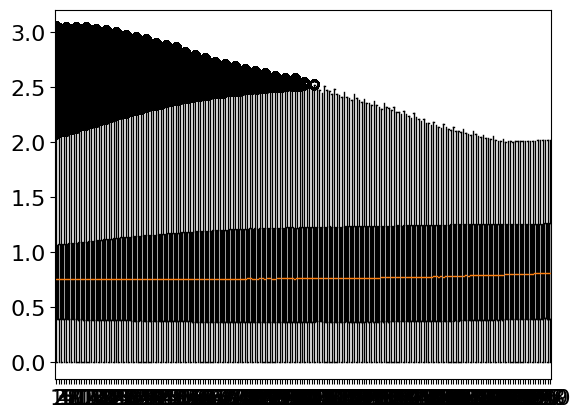

In [9]:
import matplotlib.pyplot as plt
from scipy import stats

# Assuming 'dataset' is a Pandas DataFrame
z_scores = np.abs(stats.zscore(X))
plt.boxplot(z_scores)
plt.show()

In [10]:
from scipy import stats

def remove_outliers_zscore(X, threshold=50):
    z_scores = np.abs(stats.zscore(X))
    X_no_outliers = X[(z_scores < threshold).all(axis=1)]  # Change axis to 1
    return X_no_outliers

# Assuming 'X' is a NumPy array with shape (297278, 48000)
cleaned_X = remove_outliers_zscore(X.copy())  # Create a copy to avoid modifying the original
print(cleaned_X)
X = cleaned_X


[[0.49166667 0.52407407 0.54444444 ... 0.40833333 0.31574074 0.40277778]
 [0.38333333 0.27962963 0.23796296 ... 0.4537037  0.42777778 0.30185185]
 [0.37592593 0.38611111 0.32685185 ... 0.39351852 0.275      0.28518519]
 ...
 [0.06279217 0.06314483 0.06309976 ... 0.22911281 0.2224043  0.22188724]
 [0.06607483 0.06487897 0.06546232 ... 0.27046957 0.26280649 0.21785418]
 [0.06405963 0.06365128 0.06419221 ... 0.18681208 0.17770919 0.17889975]]


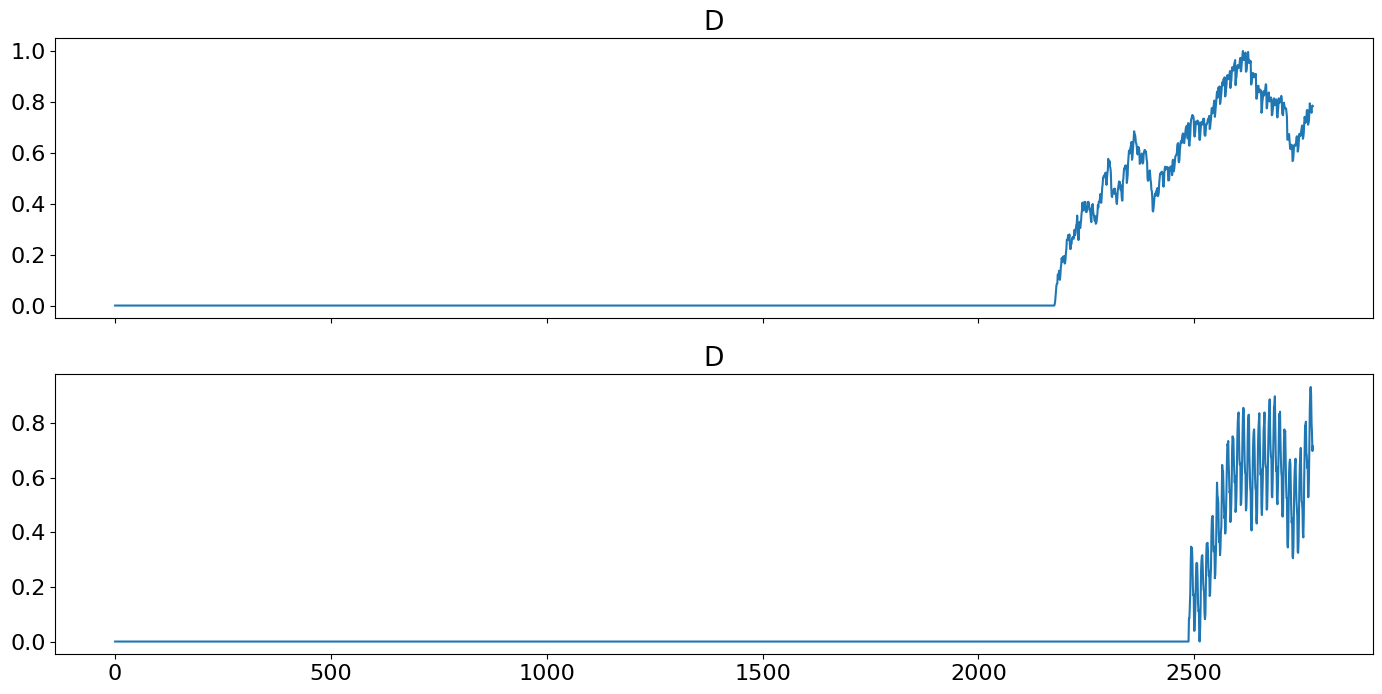

In [11]:
df = pd.DataFrame(dataset).T    # solo per visualizzare
def inspect_dataframe(df, rows):
    figs, axs = plt.subplots(len(rows), 1, sharex=True, figsize=(17,8))
    for i, col in enumerate(rows):
        axs[i].plot(df[col])
        axs[i].set_title(cat[col])
    plt.show()
inspect_dataframe(df, [2000,2004])

In [12]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,47990,47991,47992,47993,47994,47995,47996,47997,47998,47999
count,2776.000000,2776.000000,2776.000000,2776.000000,2776.000000,2776.000000,2776.000000,2776.000000,2776.000000,2776.000000,...,2776.000000,2776.000000,2776.000000,2776.000000,2776.000000,2776.000000,2776.000000,2776.000000,2776.000000,2776.000000
mean,0.054361,0.068751,0.060929,0.011670,0.018159,0.093053,0.014079,0.014560,0.135583,0.036679,...,0.009395,0.010839,0.011264,0.011262,0.010392,0.020130,0.025636,0.024214,0.023126,0.024841
std,0.140736,0.175865,0.174066,0.082121,0.105274,0.209849,0.088380,0.088222,0.235376,0.135165,...,0.070017,0.070266,0.075342,0.068756,0.067169,0.099564,0.124900,0.129294,0.124293,0.132309
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.264925,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,0.977140,1.000000,1.000000,1.000000,0.878788,0.895000,1.000000,1.000000,...,1.000000,0.898371,0.893487,0.738073,0.882692,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
X_train, X_test = np.split(X,[880000])
y_train, y_test = np.split(y,[880000])
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(297278, 200) (297278, 9) (0, 200) (0, 9)


In [15]:
X_train = np.expand_dims(X_train,axis=2)
X_train.shape

(297278, 200, 1)

In [16]:
y_train = np.expand_dims(y_train,axis=2)
y_train.shape

(297278, 9, 1)

In [17]:
y_test = np.expand_dims(y_test,axis=2)
y_test.shape

(0, 9, 1)

In [18]:
X_test = np.expand_dims(X_test,axis=2)
X_test.shape

(0, 200, 1)

In [19]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 64
epochs = 200

In [20]:
input_shape,output_shape

((200, 1), (9, 1))

In [21]:
def build_LSTM_model(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Add a Bidirectional LSTM layer with 32 units, return true very important, I want a sequence
    x = tfkl.Bidirectional(tfkl.LSTM(32, return_sequences=True, name='lstm'), name='bidirectional_lstm1')(input_layer)
    x = tfkl.Bidirectional(tfkl.LSTM(32, return_sequences=True, name='lstm'), name='bidirectional_lstm2')(x)

    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv')(x)

    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Conv1D(output_shape[1], 3, padding='same', name='output_layer')(x)

    # Calculate the size to crop from the output to match the output shape: very important because bilstm gives me same sequence length*2, so it gives me 100. But I want 50, so I need to crop, I want a telescope size
    crop_size = output_layer.shape[1] - output_shape[0]

    # Crop the output to the desired length: I take only cropped last
    output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.AdamW())

    return model

Model: "CONV_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200, 1)]          0         
                                                                 
 bidirectional_lstm1 (Bidir  (None, 200, 64)           8704      
 ectional)                                                       
                                                                 
 bidirectional_lstm2 (Bidir  (None, 200, 64)           24832     
 ectional)                                                       
                                                                 
 conv (Conv1D)               (None, 200, 128)          24704     
                                                                 
 output_layer (Conv1D)       (None, 200, 1)            385       
                                                                 
 cropping (Cropping1D)       (None, 9, 1)          

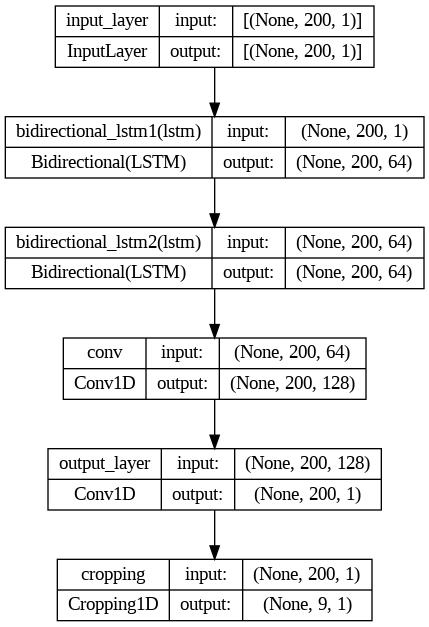

In [22]:
model = build_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [23]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/200
4181/4181 [==============================] - 146s 32ms/step - loss: 0.0337 - val_loss: 0.0099 - lr: 0.0010
Epoch 2/200
4181/4181 [==============================] - 132s 32ms/step - loss: 0.0085 - val_loss: 0.0092 - lr: 0.0010
Epoch 3/200
4181/4181 [==============================] - 130s 31ms/step - loss: 0.0076 - val_loss: 0.0088 - lr: 0.0010
Epoch 4/200
4181/4181 [==============================] - 129s 31ms/step - loss: 0.0074 - val_loss: 0.0083 - lr: 0.0010
Epoch 5/200
4181/4181 [==============================] - 128s 31ms/step - loss: 0.0072 - val_loss: 0.0082 - lr: 0.0010
Epoch 6/200
4181/4181 [==============================] - 128s 31ms/step - loss: 0.0069 - val_loss: 0.0081 - lr: 0.0010
Epoch 7/200
4181/4181 [==============================] - 127s 30ms/step - loss: 0.0068 - val_loss: 0.0079 - lr: 0.0010
Epoch 8/200
4181/4181 [==============================] - 127s 30ms/step - loss: 0.0067 - val_loss: 0.0077 - lr: 0.0010
Epoch 9/200
4181/4181 [=========================

KeyboardInterrupt: ignored

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model.save('SimpleConvLSTM_3')
del model

In [ ]:
model = tfk.models.load_model('SimpleConvLSTM_3')

In [ ]:
# Predict the test set using the model
predictions = model.predict(X_test, verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")